In [3]:
import pandas as pd
import numpy as np

## Load review dataset

In [4]:
products = pd.read_csv('amazon_baby_subset.csv')

### 1. listing the name of the first 10 products in the dataset.

In [3]:
products['name'][:10]

0    Stop Pacifier Sucking without tears with Thumb...
1      Nature's Lullabies Second Year Sticker Calendar
2      Nature's Lullabies Second Year Sticker Calendar
3                          Lamaze Peekaboo, I Love You
4    SoftPlay Peek-A-Boo Where's Elmo A Children's ...
5                            Our Baby Girl Memory Book
6    Hunnt&reg; Falling Flowers and Birds Kids Nurs...
7    Blessed By Pope Benedict XVI Divine Mercy Full...
8    Cloth Diaper Pins Stainless Steel Traditional ...
9    Cloth Diaper Pins Stainless Steel Traditional ...
Name: name, dtype: object

### 2. counting the number of positive and negative reviews.

In [5]:
print (products['sentiment'] == 1).sum()
print (products['sentiment'] == -1).sum()
print (products['sentiment']).count()

26579
26493
53072


## Apply text cleaning on the review data

### 3. load the features

In [5]:
import json
with open('important_words.json') as important_words_file:    
    important_words = json.load(important_words_file)
print important_words[:3]

[u'baby', u'one', u'great']


### 4. data transformations:
- fill n/a values in the review column with empty strings
- Remove punctuation
- Compute word counts (only for important_words)

In [6]:
products = products.fillna({'review':''})  # fill in N/A's in the review column

def remove_punctuation(text):
    import string
    return text.translate(None, string.punctuation) 

products['review_clean'] = products['review'].apply(remove_punctuation)
products.head(3)

,name,review,rating,sentiment,review_clean
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,All of my kids have cried nonstop when I tried...
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1,We wanted to get something to keep track of ou...
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1,My daughter had her 1st baby over a year ago S...


### 5. compute a count for the number of times the word occurs in the review

In [7]:
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

In [8]:
products.head(1)

,name,review,rating,sentiment,review_clean,baby,one,great,love,use,...,seems,picture,completely,wish,buying,babies,won,tub,almost,either
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,All of my kids have cried nonstop when I tried...,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


 ### 7. compute the number of product reviews that contain the word perfect.

In [9]:
products['contains_perfect'] = products['perfect'] >=1
print products['contains_perfect'].sum()

2955


## 1. Quiz Question. 
How many reviews contain the word perfect?

## Answer 
2955

## Convert data frame to multi-dimensional array

### 8.  convert our data frame to a multi-dimensional array.
The function should accept three parameters:
- dataframe: a data frame to be converted
- features: a list of string, containing the names of the columns that are used as features.
- label: a string, containing the name of the single column that is used as class labels.

The function should return two values:

- one 2D array for features
- one 1D array for class labels

The function should do the following:
- Prepend a new column constant to dataframe and fill it with 1's. This column takes account of the intercept term. Make sure that the constant column appears first in the data frame.
- Prepend a string 'constant' to the list features. Make sure the string 'constant' appears first in the list.
- Extract columns in dataframe whose names appear in the list features.
- Convert the extracted columns into a 2D array using a function in the data frame library. If you are using Pandas, you would use as_matrix() function.
- Extract the single column in dataframe whose name corresponds to the string label.
- Convert the column into a 1D array.
- Return the 2D array and the 1D array.

In [10]:
def get_numpy_data(dataframe, features, label):
    dataframe['constant'] = 1
    features = ['constant'] + features
    features_frame = dataframe[features]
    feature_matrix = features_frame.as_matrix()
    label_sarray = dataframe[label]
    label_array = label_sarray.as_matrix()
    return(feature_matrix, label_array)

### 9. extract two arrays feature_matrix and sentiment

In [11]:
feature_matrix, sentiment = get_numpy_data(products, important_words, 'sentiment')

## 2. Quiz Question: 
How many features are there in the feature_matrix?

In [12]:
print feature_matrix.shape

(53072L, 194L)


## 2. Answer:
194

## 3. Quiz Question: 
Assuming that the intercept is present, how does the number of features in feature_matrix relate to the number of features in the logistic regression model?

## Estimating conditional probability with link function

### 10. Compute predictions given by the link function.
- Take two parameters: feature_matrix and coefficients.
- First compute the dot product of feature_matrix and coefficients.
- Then compute the link function P(y=+1|x,w).
- Return the predictions given by the link function.

In [19]:
'''
feature_matrix: N * D
coefficients: D * 1
predictions: N * 1
produces probablistic estimate for P(y_i = +1 | x_i, w).
estimate ranges between 0 and 1.
'''

def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients  
    # YOUR CODE HERE
    score = np.dot(feature_matrix, coefficients) # N * 1
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    # YOUR CODE HERE
    predictions = 1.0/(1+np.exp(-score))
    
    # return predictions
    return predictions

## Compute derivative of log likelihood with respect to a single coefficient

### 11. computes the derivative of log likelihood with respect to a single coefficient w_j
The function should do the following:

- Take two parameters errors and feature.
- Compute the dot product of errors and feature.
- Return the dot product. This is the derivative with respect to a single coefficient w_j.

In [14]:
"""
errors: N * 1
feature: N * 1
derivative: 1 
"""
def feature_derivative(errors, feature):     
    # Compute the dot product of errors and feature
    derivative = np.dot(np.transpose(errors), feature)
    # Return the derivative
    return derivative

### 12. Write a function compute_log_likelihood

In [15]:
def compute_log_likelihood(feature_matrix, sentiment, coefficients):
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    # scores.shape (53072L, 1L)
    # indicator.shape (53072L,)
    lp = np.sum((np.transpose(np.array([indicator]))-1)*scores - np.log(1. + np.exp(-scores)))
    return lp

## Taking gradient steps

### 13. Write a function logistic_regression to fit a logistic regression model using gradient ascent.
The function accepts the following parameters:

- feature_matrix: 2D array of features
- sentiment: 1D array of class labels
- initial_coefficients: 1D array containing initial values of coefficients
- step_size: a parameter controlling the size of the gradient steps
- max_iter: number of iterations to run gradient ascent
- The function returns the last set of coefficients after performing gradient ascent.

The function carries out the following steps:

1. Initialize vector coefficients to initial_coefficients.
1. Predict the class probability P(yi=+1|xi,w) using your predict_probability function and save it to variable predictions.
1. Compute indicator value for (yi=+1) by comparing sentiment against +1. Save it to variable indicator.
1. Compute the errors as difference between indicator and predictions. Save the errors to variable errors.
1. For each j-th coefficient, compute the per-coefficient derivative by calling feature_derivative with the j-th column of feature_matrix. Then increment the j-th coefficient by (step_size*derivative).
1. Once in a while, insert code to print out the log likelihood.
1. Repeat steps 2-6 for max_iter times.

In [35]:
# coefficients: D * 1
from math import sqrt
def logistic_regression(feature_matrix, sentiment, initial_coefficients, step_size, max_iter):
    coefficients = np.array(initial_coefficients) # make sure it's a numpy array
    # lplist = []
    for itr in xrange(max_iter):
        # Predict P(y_i = +1|x_1,w) using your predict_probability() function
        # YOUR CODE HERE
        predictions = predict_probability(feature_matrix, coefficients)

        # Compute indicator value for (y_i = +1)
        indicator = (sentiment==+1)

        # Compute the errors as indicator - predictions
        errors = np.transpose(np.array([indicator])) - predictions

        for j in xrange(len(coefficients)): # loop over each coefficient
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j]
            # compute the derivative for coefficients[j]. Save it in a variable called derivative
            # YOUR CODE HERE
            derivative = feature_derivative(errors, feature_matrix[:,j])

            # add the step size times the derivative to the current coefficient
            # YOUR CODE HERE
            coefficients[j] += step_size*derivative

        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            # lplist.append(compute_log_likelihood(feature_matrix, sentiment, coefficients))
            lp = compute_log_likelihood(feature_matrix, sentiment, coefficients)
            print 'iteration %*d: log likelihood of observed labels = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, lp)
    """
    import matplotlib.pyplot as plt
    x= [i for i in range(len(lplist))]
    plt.plot(x,lplist,'ro')
    plt.show()
    """
    return coefficients

### 14. run the logistic regression solver
- feature_matrix = feature_matrix extracted in #9
- sentiment = sentiment extracted in #9
- initial_coefficients = a 194-dimensional vector filled with zeros
- step_size = 1e-7
- max_iter = 301

In [17]:
initial_coefficients = np.zeros((194,1))
step_size = 1e-7
max_iter = 301

In [20]:
coefficients = logistic_regression(feature_matrix, sentiment, initial_coefficients, step_size, max_iter)

iteration   0: log likelihood of observed labels = -36780.91768478
iteration   1: log likelihood of observed labels = -36775.13434712
iteration   2: log likelihood of observed labels = -36769.35713564
iteration   3: log likelihood of observed labels = -36763.58603240
iteration   4: log likelihood of observed labels = -36757.82101962
iteration   5: log likelihood of observed labels = -36752.06207964
iteration   6: log likelihood of observed labels = -36746.30919497
iteration   7: log likelihood of observed labels = -36740.56234821
iteration   8: log likelihood of observed labels = -36734.82152213
iteration   9: log likelihood of observed labels = -36729.08669961
iteration  10: log likelihood of observed labels = -36723.35786366
iteration  11: log likelihood of observed labels = -36717.63499744
iteration  12: log likelihood of observed labels = -36711.91808422
iteration  13: log likelihood of observed labels = -36706.20710739
iteration  14: log likelihood of observed labels = -36700.5020

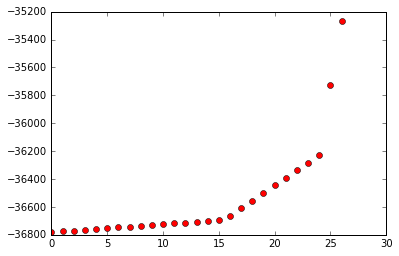

In [34]:
coefficients = logistic_regression(feature_matrix, sentiment, initial_coefficients, step_size, max_iter)

## 5. Quiz question : 
As each iteration of gradient ascent passes, does the log likelihood increase or decrease?

### Answer
increase

### 15. compute class predictions
- First compute the scores using feature_matrix and coefficients using a dot product.
- Then apply threshold 0 on the scores to compute the class predictions. Refer to the formula above.

In [36]:
"""
feature_matrix: N * D
coefficients: D * 1
predictions: N * 1
"""
predictions = predict_probability(feature_matrix, coefficients)
NumPositive = (predictions > 0.5).sum()
print NumPositive

score = np.dot(feature_matrix, coefficients) # N * 1
print (score > 0).sum()

25126
25126


### 6. Quiz question: 
How many reviews were predicted to have positive sentiment?

### Answer:
25126

## Measuring accuracy

In [22]:
print 0 in products['sentiment']

True


In [23]:
print -1 in products['sentiment']

False


In [24]:
print np.transpose(predictions.flatten()).shape
print (products['sentiment']).shape

(53072L,)
(53072L,)


In [25]:
print (np.transpose(predictions.flatten()))[:5]

[ 0.51275866  0.49265935  0.50602867  0.50196725  0.53290719]


In [46]:
correct_num = np.sum((np.transpose(predictions.flatten())> 0.5) == np.array(products['sentiment']>0))
total_num = len(products['sentiment'])
print "correct_num: {}, total_num: {}".format(correct_num, total_num)
accuracy = correct_num * 1./ total_num
print accuracy

correct_num: 39903, total_num: 53072
0.751865390413


In [39]:
np.transpose(predictions.flatten())> 0.5


array([ True, False,  True, ..., False,  True, False], dtype=bool)

In [45]:
np.array(products['sentiment']>0)

array([ True,  True,  True, ..., False, False, False], dtype=bool)

In [48]:
correct_num = np.sum((np.transpose(score.flatten())> 0) == np.array(products['sentiment']>0))
total_num = len(products['sentiment'])
print "correct_num: {}, total_num: {}".format(correct_num, total_num)
accuracy = correct_num * 1./ total_num
print accuracy

correct_num: 39903, total_num: 53072
0.751865390413


### 7. Quiz question: 
What is the accuracy of the model on predictions made above? (round to 2 digits of accuracy)

### Answer:
0.75

## Which words contribute most to positive & negative sentiments

### 17.compute the "most positive words"
- Treat each coefficient as a tuple, i.e. (word, coefficient_value). The intercept has no corresponding word, so throw it out.
- Sort all the (word, coefficient_value) tuples by coefficient_value in descending order. Save the sorted list of tuples to word_coefficient_tuples.

In [28]:
coefficients = list(coefficients[1:]) # exclude intercept
word_coefficient_tuples = [(word, coefficient) for word, coefficient in zip(important_words, coefficients)]
word_coefficient_tuples = sorted(word_coefficient_tuples, key=lambda x:x[1], reverse=True)

## Ten "most positive" words

### 18. Compute the 10 most positive words

In [29]:
word_coefficient_tuples[:10]

[(u'great', array([ 0.06654608])),
 (u'love', array([ 0.06589076])),
 (u'easy', array([ 0.06479459])),
 (u'little', array([ 0.04543563])),
 (u'loves', array([ 0.0449764])),
 (u'well', array([ 0.030135])),
 (u'perfect', array([ 0.02973994])),
 (u'old', array([ 0.02007754])),
 (u'nice', array([ 0.01840871])),
 (u'daughter', array([ 0.0177032]))]

### 8. Quiz question: 
Which word is not present in the top 10 "most positive" words?

## Ten "most negative" words

In [30]:
word_coefficient_tuples[-10:]

[(u'monitor', array([-0.0244821])),
 (u'return', array([-0.02659278])),
 (u'back', array([-0.0277427])),
 (u'get', array([-0.02871155])),
 (u'disappointed', array([-0.02897898])),
 (u'even', array([-0.03005125])),
 (u'work', array([-0.03306952])),
 (u'money', array([-0.03898204])),
 (u'product', array([-0.04151103])),
 (u'would', array([-0.05386015]))]

### 9. Quiz question: 
Which word is not present in the top 10 "most negative" words?

In [31]:
print np.array([1,2,3])==np.array([1,3,2])

[ True False False]
